<a href="https://colab.research.google.com/github/cedro3/others/blob/master/ArtLine_gif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ArtLine_gif**
**Create** **Amazing** **Line** **Art**.

In [1]:
# copy github
!git clone https://github.com/vijishmadhavan/ArtLine.git ArtLine
%cd ArtLine/

# get libralies
!pip install -r colab_requirements.txt
!pip install -q youtube-dl

Cloning into 'ArtLine'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 408 (delta 131), reused 0 (delta 0), pack-reused 194
Receiving objects: 100% (408/408), 345.34 KiB | 1.17 MiB/s, done.
Resolving deltas: 100% (200/200), done.
/content/ArtLine
     |████████████████████████████████| 20.4MB 1.4MB/s 
     |████████████████████████████████| 10.5MB 51.1MB/s 
     |████████████████████████████████| 748.8MB 23kB/s 
     |████████████████████████████████| 5.9MB 52.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5

     |████████████████████████████████| 1.9MB 12.8MB/s 


# **Runtime**

* Hardware Accelerator = GPU              
You have to click twice


In [3]:
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
import numpy as np
import urllib.request
import PIL.Image
from io import BytesIO
import torchvision.transforms as T
from PIL import Image
import requests
from io import BytesIO
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
import numpy as np
import urllib.request
import PIL.Image
from io import BytesIO
import torchvision.transforms as T

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [4]:
MODEL_URL = "https://www.dropbox.com/s/p9lynpwygjmeed2/ArtLine_500.pkl?dl=1 "
urllib.request.urlretrieve(MODEL_URL, "ArtLine_500.pkl")
path = Path(".")
learn=load_learner(path, 'ArtLine_500.pkl')

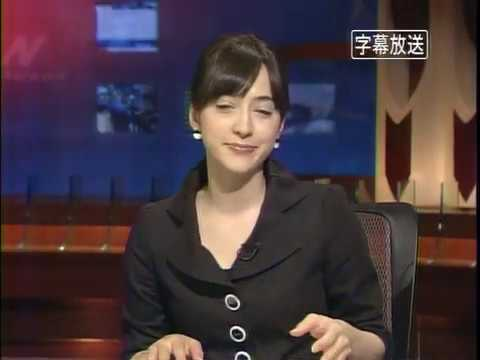

In [5]:
# check YouTubeVideo
from IPython.display import YouTubeVideo
YOUTUBE_ID ='m0u0uAhoxq4'
YouTubeVideo(YOUTUBE_ID)

In [6]:
# download YouTubeVideo
!rm -rf youtube.mp4
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID

[youtube] m0u0uAhoxq4: Downloading webpage
[youtube] m0u0uAhoxq4: Downloading MPD manifest
[dashsegments] Total fragments: 6
[download] Destination: youtube.mp4
[download] 100% of 1.26MiB in 00:00


In [7]:
# edit YouTubeVideo
import os
os.makedirs('video', exist_ok=True)
!ffmpeg -i youtube.mp4 -filter:v 'crop=300:300:170:0' -ss 00:00:01 -t 00:00:02 -async 1 ./video/takikuri.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [8]:
# video2frames
import os
import cv2

os.makedirs('images', exist_ok=True)
 
def video_2_frames(video_file='./video/takikuri.mp4', 
                   image_dir='./images/', 
                   image_file='img_%s.png'):
 
    # Initial setting
    i = 0
    interval = 3
    length = 30
    
    cap = cv2.VideoCapture(video_file)
    while(cap.isOpened()):
        flag, frame = cap.read()  
        if flag == False:  
                break
        if i == length*interval:
                break
        if i % interval == 0:    
           cv2.imwrite(image_dir+image_file % str(i).zfill(6), frame)
           print('Save', image_dir+image_file % str(i).zfill(6))
        i += 1 
    cap.release()  
 
def main():
    video_2_frames()
    
if __name__ == '__main__':
    main()  


Save ./images/img_000000.png
Save ./images/img_000003.png
Save ./images/img_000006.png
Save ./images/img_000009.png
Save ./images/img_000012.png
Save ./images/img_000015.png
Save ./images/img_000018.png
Save ./images/img_000021.png
Save ./images/img_000024.png
Save ./images/img_000027.png
Save ./images/img_000030.png
Save ./images/img_000033.png
Save ./images/img_000036.png
Save ./images/img_000039.png
Save ./images/img_000042.png
Save ./images/img_000045.png
Save ./images/img_000048.png
Save ./images/img_000051.png
Save ./images/img_000054.png
Save ./images/img_000057.png


In [9]:
# frames2ArtLines
import os
import torchvision.utils as vutils

os.makedirs('out', exist_ok=True)

input_path = './images' 
output_path = './out'
files = os.listdir(input_path)
files.sort()

temp =[add_metrics]

for file in files:
  print(file)
  if file == '.ipynb_checkpoints':
     continue
  img = PIL.Image.open(input_path+'/'+file).convert("RGB")
  img_t = T.ToTensor()(img)
  img_fast = Image(img_t)
  p,img_hr,b = learn.predict(img_fast)
  vutils.save_image(img_hr,output_path+'/'+file)
 

img_000000.png
img_000003.png
img_000006.png
img_000009.png
img_000012.png
img_000015.png
img_000018.png
img_000021.png
img_000024.png
img_000027.png
img_000030.png
img_000033.png
img_000036.png
img_000039.png
img_000042.png
img_000045.png
img_000048.png
img_000051.png
img_000054.png
img_000057.png


In [10]:
# ArtLines2GIF
from PIL import Image
import glob
 
files = sorted(glob.glob('./out/*.png'))
images = list(map(lambda file: Image.open(file), files))
images[0].save('./takikuri.gif', save_all=True, 
               append_images=images[1:], 
               duration=100, loop=0)

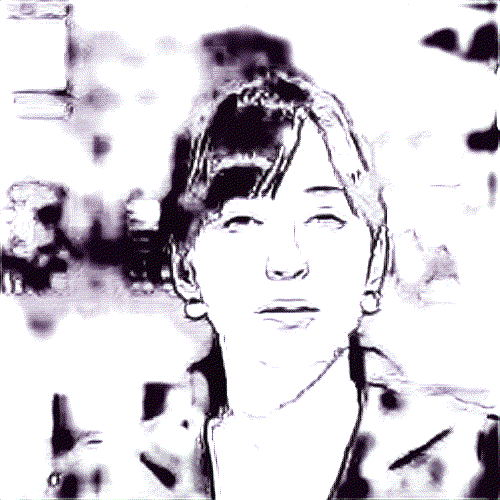

In [11]:
# display GIF
from IPython.display import Image
Image('./takikuri.gif', format='png')